In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from hyperopt import Trials,STATUS_OK,tpe, hp, fmin

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [69]:
# 데이터 처리 
def get_data():
    train = pd.read_csv('../data/titanic/train.csv')
    test = pd.read_csv('../data/titanic/test.csv')
    all_data = pd.concat([train,test]).reset_index(drop=True)
    
    # 타이틀 처리
    all_data['Title'] = all_data['Name'].str.extract(' ([A-Za-z]+)\.')
    all_data['Title'].replace(['Lady', 'Countess','Capt', 'Col'
                               ,'Don', 'Dr', 'Major', 'Rev', 'Sir'
                               , 'Jonkheer', 'Dona'], 'Other',inplace=True)
    all_data['Title'].replace('Mlle', 'Miss',inplace=True)
    all_data['Title'].replace('Ms', 'Miss',inplace=True)
    all_data['Title'].replace('Mme', 'Mrs',inplace=True)

    # Fare, Embarked, Cabin 처리
    all_data['Fare'].fillna(all_data.groupby('Pclass')['Fare'].transform('median'),inplace=True)
    all_data['Embarked'].fillna('C',inplace=True)
    all_data['Cabin'] = all_data['Cabin'].str[0:1]
    # cabin에 하나밖에 었는 T는 pclass가 1 이므로 A로 대체
    all_data.loc[all_data['Cabin']=='T','Cabin'] = 'A'
    return all_data

def get_mapping(all_data):
    all_data['Sex'] = all_data['Sex'].map({'male' : 0, 'female' : 1})
    
    # title mapping
    title_mapping = {
    'Mr':0, 'Miss':1, 'Mrs':2, 'Master':3, 'Other':4}
    all_data['Title'] = all_data['Title'].map(title_mapping)
    
def check(df,col=None,x=None,y=None):
    facet=sns.FacetGrid(df,hue='Survived',aspect=4)
    facet.map(sns.kdeplot,col)
    facet.set(xlim=(0,df[col].max()))
    facet.add_legend
    plt.xlim(x,y)
    
def del_data(all_data,list_):
    all_data.drop(list_,axis=1,inplace=True)
    return all_data
    
# 각 컬럼별 상관 관계 확인
# corr-> 각 피쳐 끼리의 상관 관계
def corr_df(df,col=None):
   all_data_corr = df.corr(method='pearson').abs().stack().sort_values(ascending=False).reset_index()
   return  all_data_corr[all_data_corr['level_0']==col]

In [70]:
all_data = get_data()
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB


In [71]:
get_mapping(all_data)
all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C,C,2
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C,S,2
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0


### 형제,부모 합쳐서 Family, 없으면 solo컬럼 생성

In [72]:
# family만들기
all_data['Family'] = all_data['SibSp'] + all_data['Parch']

# # Solo생성
all_data['Solo'] = all_data['Family'].apply(lambda x : 1  if x==0 else 0)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   int64  
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1309 non-null   object 
 12  Title        1309 non-null   int64  
 13  Family       1309 non-null   int64  
 14  Solo         1309 non-null   int64  
dtypes: float64(3), int64(8), object(4)
memory usage: 153.5+ KB


In [73]:
list_ = ['Name','SibSp','Parch','Ticket','Embarked']
del_data(all_data,list_)
all_data

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Title,Family,Solo
0,1,0.0,3,0,22.0,7.2500,NaN,0,1,0
1,2,1.0,1,1,38.0,71.2833,C,2,1,0
2,3,1.0,3,1,26.0,7.9250,NaN,1,0,1
3,4,1.0,1,1,35.0,53.1000,C,2,1,0
4,5,0.0,3,0,35.0,8.0500,NaN,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,0,NaN,8.0500,NaN,0,0,1
1305,1306,NaN,1,1,39.0,108.9000,C,4,0,1
1306,1307,NaN,3,0,38.5,7.2500,NaN,0,0,1
1307,1308,NaN,3,0,NaN,8.0500,NaN,0,0,1


### age 결측치 처리
- age가 nan이 아닌 데이터로 회귀 학습
- age의 nan값을 예측 

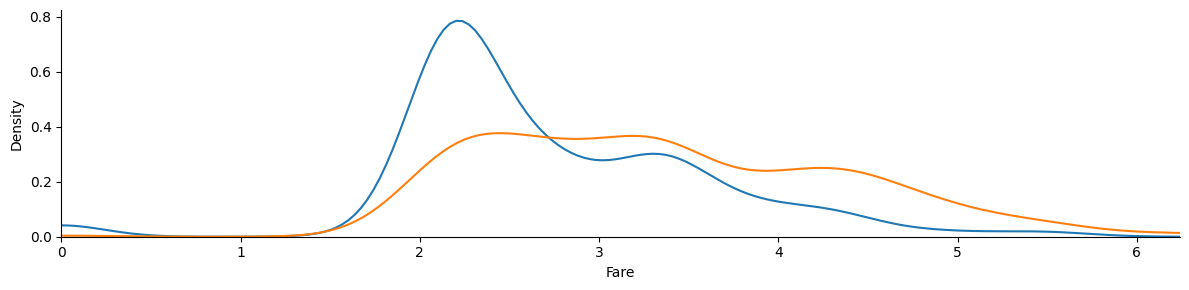

In [74]:
# 한쪽으로 치우친 Fare -> 벨커브 만들기
all_data['Fare'] = np.log1p(all_data['Fare'])
check(all_data,'Fare')

In [75]:
# 데이터 셋에서 age가 nan이 아닌 놈들 추출
age_train = all_data.dropna(subset=['Age'])
age_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046 entries, 0 to 1306
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1046 non-null   int64  
 1   Survived     714 non-null    float64
 2   Pclass       1046 non-null   int64  
 3   Sex          1046 non-null   int64  
 4   Age          1046 non-null   float64
 5   Fare         1046 non-null   float64
 6   Cabin        272 non-null    object 
 7   Title        1046 non-null   int64  
 8   Family       1046 non-null   int64  
 9   Solo         1046 non-null   int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 89.9+ KB


In [76]:
# age 예측을 위한 train set
age_train_X = age_train[['Pclass','Family','Fare','Solo']]
age_train_y = age_train[['Age']]

In [77]:
# age 예측용 test 
age_test_X = all_data[all_data['Age'].isnull()]
age_test_X = age_test_X[['Pclass','Family','Fare','Solo']]
age_test_X

,Pclass,Family,Fare,Solo
5,3,0,2.246893,1
17,2,0,2.639057,1
19,3,0,2.107178,1
26,3,0,2.107178,1
28,3,0,2.183711,1
...,...,...,...,...
1299,3,0,2.165711,1
1301,3,0,2.169054,1
1304,3,0,2.202765,1
1307,3,0,2.202765,1


In [78]:
age_train_y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1046 entries, 0 to 1306
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     1046 non-null   float64
dtypes: float64(1)
memory usage: 16.3 KB


In [79]:
# 학습
ridge = Lasso()
ridge.fit(age_train_X,age_train_y)

# 예측
pred_rid = abs(ridge.predict(age_test_X))
print(pred_rid)

[27.20553744 32.66022196 27.20553744 27.20553744 27.20553744 27.20553744
 36.33099796 27.20553744 27.20553744 27.20553744 27.20553744 25.42162892
 27.20553744 23.6377204  38.11490648 38.11490648 23.6377204  27.20553744
 27.20553744 27.20553744 27.20553744 27.20553744 27.20553744 27.20553744
 25.42162892 27.20553744 27.20553744 23.6377204  23.6377204  27.20553744
 27.20553744  9.36645222 36.33099796 38.11490648 20.06990335  9.36645222
 32.66022196 38.11490648 25.42162892 27.20553744 27.20553744  9.36645222
 25.42162892 27.20553744 20.06990335 27.20553744 25.42162892 25.42162892
 27.20553744 38.11490648 27.20553744 27.20553744 38.11490648 27.20553744
 32.66022196 38.11490648 38.11490648 38.11490648 27.20553744 23.6377204
 32.66022196 27.20553744 38.11490648  9.36645222 23.6377204  36.33099796
 27.20553744 25.42162892 38.11490648 27.20553744 27.20553744 27.20553744
 25.42162892 27.20553744 27.20553744 36.33099796 27.20553744 27.20553744
 20.06990335 27.20553744 27.20553744 32.66022196 27.

In [80]:
# 예측값을 데이터셋 age와 맵핑
for i in tqdm(range(len(all_data))):
    if np.isnan(all_data.iloc[i,4]) == True:
        for j in range(len(pred_rid)):
            all_data.iloc[i,4]=pred_rid[j]
    else:
        pass
all_data['Age'].isnull().sum()

100%|██████████| 1309/1309 [00:04<00:00, 311.28it/s]


0

### cabin 결측치 처리
- cabin이 nan이 아닌 데이터로 학습[Pclass, Fare]
- 예측
- RandomForest 사용

In [81]:
# 데이터 셋에서 cabin이 nan이 아닌 놈들만 추출
cabin_train = all_data.dropna(subset=['Cabin'])
cabin_train

,PassengerId,Survived,Pclass,Sex,Age,Fare,Cabin,Title,Family,Solo
1,2,1.0,1,1,38.0,4.280593,C,2,1,0
3,4,1.0,1,1,35.0,3.990834,C,2,1,0
6,7,0.0,1,0,54.0,3.967694,E,0,0,1
10,11,1.0,3,1,4.0,2.873565,G,1,2,0
11,12,1.0,1,1,58.0,3.316003,C,1,0,1
...,...,...,...,...,...,...,...,...,...,...
1295,1296,NaN,1,0,43.0,3.357622,D,0,1,0
1296,1297,NaN,2,0,20.0,2.698841,D,0,0,1
1298,1299,NaN,1,0,50.0,5.358942,C,0,2,0
1302,1303,NaN,1,1,37.0,4.510860,C,2,1,0


In [82]:
# cabin 학습을 위한 train set
cabin_train_X = cabin_train[['Pclass','Fare','Family']]
# cabin은 object이므로 원핫 인코딩 진행
cabin_train_y = pd.get_dummies(cabin_train['Cabin'])

In [83]:
# 예측용 test
cabin_test = all_data[all_data['Cabin'].isnull()]
cabin_test_X = cabin_test[['Pclass','Fare','Family']]
cabin_test_X

,Pclass,Fare,Family
0,3,2.110213,1
2,3,2.188856,0
4,3,2.202765,0
5,3,2.246893,0
7,3,3.094446,4
...,...,...,...
1303,3,2.171907,0
1304,3,2.202765,0
1306,3,2.110213,0
1307,3,2.202765,0


In [84]:
# 학습
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(cabin_train_X,cabin_train_y)

# # 예측 
pred_rf = rf_clf.predict(cabin_test_X)
pred_rf

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

In [85]:
# all_data cabin과 mapping
# 전체행(1309)를 cabin get_dummies로 받아서 예측값을 대입후 다시 all_data와 concat
# 1. 전체 cabin get_dummies로 추출 
all_data_cabin = pd.get_dummies(all_data['Cabin'])

# 2. 예측값과 매칭
for i in tqdm(range(len(all_data))):
    if all_data_cabin.sum(axis=1)[i] == 0:
        for j in range(len(pred_rf)):
            all_data_cabin.iloc[i] = pred_rf[j]
    else:
        pass
all_data_cabin.sum()

100%|██████████| 1309/1309 [00:24<00:00, 53.10it/s]


A      23
B      65
C      94
D      46
E      41
F    1035
G       5
dtype: int64

In [86]:
all_data = pd.concat([all_data,all_data_cabin],axis=1)
del_data(all_data,['Cabin','A','B','C','D','E','F','G'])
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Sex          1309 non-null   int64  
 4   Age          1309 non-null   float64
 5   Fare         1309 non-null   float64
 6   Title        1309 non-null   int64  
 7   Family       1309 non-null   int64  
 8   Solo         1309 non-null   int64  
dtypes: float64(3), int64(6)
memory usage: 92.2 KB


### 구간 나누기

In [87]:
all_data['Age'] = pd.qcut(all_data['Age'],4)
all_data['Age'].value_counts()

(22.0, 24.0]     338
(0.169, 22.0]    333
(35.0, 80.0]     322
(24.0, 35.0]     316
Name: Age, dtype: int64

In [88]:
all_data['Age'] = LabelEncoder().fit_transform(all_data['Age'])
all_data['Age'].value_counts()

1    338
0    333
3    322
2    316
Name: Age, dtype: int64

### 학습데이터와 테스트 데이터 분리

In [89]:
train = all_data[all_data['Survived'].notnull()]
test = all_data[all_data['Survived'].isnull()]

In [90]:
train_X = train.drop(['Survived','PassengerId'],axis=1)
train_y = train['Survived']

In [91]:
test_X = test.drop(['Survived','PassengerId'],axis=1)

### 학습 예측

In [92]:
X_train,X_test,y_train,y_test = \
    train_test_split(
        train_X,train_y
        ,test_size=0.2
        ,random_state=42
        ,stratify=train_y
    )

In [93]:
xgb_clf = XGBClassifier(eval_metric='logloss',random_state=42)
lr_clf = LogisticRegression(random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
gb_clf = GradientBoostingClassifier(random_state=42)
sv_clf = SVC(random_state=42)
clfs = [xgb_clf,lr_clf,rf_clf,gb_clf,sv_clf]
skf = StratifiedKFold(n_splits=10,random_state=42,shuffle=True)
scoring = 'accuracy'

In [94]:
for clf in clfs:
    score = cross_val_score(
        clf,X_train,y_train,cv=skf,scoring=scoring
    )
    print('model : {0} , score : {1:.3f}'.format(clf,score.mean()))

model : XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='logloss', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None) , score : 0.829
model : LogisticRegression(random_state=42) , score : 0.810
model : RandomForestClassifier(random_state=42) , score : 0.802
model : GradientBoostingClassifier(random_state=42) , score : 0.840
model : SVC(random_state=42) , score : 0.833


### 하이퍼 파라미터 튜닝

In [95]:
# space 정의
space = {
      'n_estimators': hp.quniform('n_estimators', 200, 1500, 100),
      'max_depth': hp.quniform("max_depth", 2, 15, 1),
      'learning_rate': hp.quniform ('learning_rate', 0.1, 1, 0.01),
      'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
      'colsample_bytree' : hp.quniform('colsample_bytree', 0.6, 1, 0.05),
      'min_child_weight' : hp.quniform('min_child_weight', 1, 20, 1),
}

In [96]:
# 목적함수 설정
def tuning(space):
    clf = XGBClassifier(
        n_estimators =int(space['n_estimators']), 
        max_depth = int(space['max_depth']), 
        learning_rate = space['learning_rate'],
        subsample = space['subsample'],
        colsample_bytree = space['colsample_bytree'], 
        min_child_weight = int(space['min_child_weight']),
        random_state=42 
    )
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(train_X,train_y
            , eval_set=evaluation
            , early_stopping_rounds=100
            , eval_metric='logloss'
            , verbose=0
    )
    
    pred = clf.predict(X_test)
    score = accuracy_score(pred,y_test)
    
    return{'loss':score,'status':STATUS_OK}

In [97]:
# Trials 객체 선언
trials = Trials()
best = fmin(
      fn=tuning
    , space=space
    , algo = tpe.suggest
    , max_evals=50
    , trials=trials
)

100%|██████████| 50/50 [00:13<00:00,  3.84trial/s, best loss: 0.8156424581005587]


In [98]:
# 최적화된 결과를 int로 변환해야하는 파라미터는 타입 변환을 수행합니다.
best['n_estimators'] = int(best['n_estimators']) # type: ignore
best['max_depth'] = int(best['max_depth']) # type: ignore
best['learning_rate'] = best['learning_rate']
best['subsample'] = best['subsample']
best['colsample_bytree'] = best['colsample_bytree'] 
best['min_child_weight'] = int(best['min_child_weight']) # type: ignore
best['random_state'] = 42 # type: ignore
print (best)

{'colsample_bytree': 0.75, 'learning_rate': 0.92, 'max_depth': 4, 'min_child_weight': 20, 'n_estimators': 600, 'subsample': 0.55, 'random_state': 42}


In [99]:
clf = XGBClassifier(**best)  # 베스트 파라미터로 object 생성  
clf.fit(X_train,y_train
        , eval_metric='logloss'
        )
prediction = clf.predict(X_test)
accuracy_score(prediction,y_test)

0.7821229050279329

### 테스트

In [100]:
clf = XGBClassifier(**best)  # 베스트 파라미터로 object 생성  
clf.fit(train_X,train_y
        , eval_metric='logloss'
        )
prediction = clf.predict(test_X)

In [101]:
submission = pd.DataFrame({
 "PassengerId": test["PassengerId"],
 "Survived": prediction.astype('int')
 })
submission.to_csv('submission.csv', index=False)
submission.head(10)

,PassengerId,Survived
891,892,0
892,893,0
893,894,0
894,895,0
895,896,1
896,897,0
897,898,0
898,899,0
899,900,1
900,901,0


In [102]:
### 0.799